In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import time
from termcolor import colored
from tqdm.notebook import tqdm
from collections import defaultdict

## Late Residual Neural Network Class

In [3]:
class ResidualBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.residual_connection = torch.nn.Identity()
        
    def forward (self, x):
        return self.residual_connection(x)


In [4]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_list, n_outputs, method=None, verbose=False):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        self.verbose = verbose
      
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_list == 0 or n_hiddens_list == [] or n_hiddens_list == [0]:
            layers = torch.nn.Linear(n_inputs, n_outputs)
            
        else:
            self.input_layer = torch.nn.Linear(n_inputs, n_hiddens_list[0])
            self.input_relu = torch.nn.ReLU()
            
            layers = []
            self.residual_layers = []
            self.regular_layers = []
            
            for nh in n_hiddens_list[:-1]:
                self.regular_layers.append(torch.nn.Linear(n_inputs, nh))
                layers.append(self.regular_layers[-1])
                self.regular_layers.append(torch.nn.ReLU())
                layers.append(self.regular_layers[-1])
                n_inputs = nh
                self.residual_layers.append(self.get_residual_layer())
                layers.append(self.residual_layers[-1])
                
                
            layers.append(torch.nn.Linear(n_inputs, n_hiddens_list[-1]))
            layers.append(torch.nn.ReLU())
            self.output_layer = torch.nn.Linear(2*len(n_hiddens_list), n_outputs)
            layers.append(self.output_layer)
            
            self.model = torch.nn.Sequential(*layers)
            
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        self.method = method
        
    def get_residual_layer(self):
        layers = []
        layers.append(ResidualBlock())
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):

        residual_outs = []
        self.layer_outputs = []
        
        for index, layer in enumerate(self.model):
            if index != len(self.model)-1:
                # For Regular Layers          
                if isinstance(layer, torch.nn.Linear):
                    x = layer(x)
                elif isinstance(layer, torch.nn.ReLU):
                    x = layer(x)
                    self.layer_outputs.append(x.detach().numpy())

                # For Residual Layers
                elif isinstance(layer, torch.nn.Sequential):
                    residual_outs.append(x)
                else:
                    raise Exception(f'{layer} is not an appropriate layer.')
        
        # Concat all residual outs and normal out
        # push through to the outputlayer
        residual_outs.append(x)
        all_outs = torch.cat(tuple(residual_outs),dim=1)        
        x = self.output_layer(all_outs)

        return x
        

    def train(self, X, T, n_epochs, learning_rate, train_style, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1

            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = None
        if self.method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        elif self.method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        else:
            raise Exception(f'Must select Adam or SGD Optimizer. Got {self.method}')
        mse_func = torch.nn.MSELoss()

        unstndErr = lambda err:(torch.sqrt(err) * self.Tstds)[0]

        for epoch in range(n_epochs):
            
            # Compute Prediction and loss
            if train_style == 'batch':
                Y = self.forward(X)
                mse = mse_func(T, Y)
            else:
                Y = self.forward(X[epoch % len(X)].reshape(-1,1))
                mse = mse_func(T[epoch % len(T)].reshape(-1,1), Y)
            
            # Backpropigation
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
          
            self.error_trace.append(unstndErr(mse))
            
            if verbose and ((epoch+1 == n_epochs) or np.mod(epoch+1 , (n_epochs // 10)) == 0):
                print(f'Epoch {epoch + 1}: RMSE {self.error_trace[-1]:.3f}')
            

    def use(self, X):
 
       # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        # Standardize X

        X = (X - self.Xmeans) / self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Y = self.forward(X)
        Y = (Y * self.Tstds) + self.Tmeans
        # Return output Y after detaching from computation graph and converting to numpy

        return Y.detach().numpy()
    

    def orig_dead_neurons(self):
        num_of_dead_neurons = 0
        for layer in self.layer_outputs:
            if (np.all(layer.T[0] == 0)):
                num_of_dead_neurons += 1
            if (np.all(layer.T[1] == 0)):
                num_of_dead_neurons += 1

        
        print(f'Total number of dead neurons: {num_of_dead_neurons}\n')

        return num_of_dead_neurons


    def dead_neurons(self, verbose=True):
        hidden_layers = self.layer_outputs
        first_neurons = []
        second_neurons = []
        dead_layers = []
        for layer, index in zip(hidden_layers, range(len(hidden_layers))):
            first_dead, second_dead = False, False
            if (np.all(layer.T[0] == 0)):
                first_neurons.append(index)
                first_dead = True
            if (np.all(layer.T[1] == 0)):
                second_neurons.append(index) 
                second_dead = True
            if first_dead and second_dead:
                dead_layers.append(index)

        if verbose:
            print(f'Total number of dead neurons: {len(first_neurons) + len(second_neurons)}\n')
            if len(first_neurons) + len(second_neurons) > 0:
                for layer in first_neurons:
                    print(f'Hidden Layer: {layer}. First Neuron.')

                print('\n')
                for layer in second_neurons:
                    print(f'Hidden Layer: {layer}. Second Neuron.')

                print('\n')  
                print(f'Total dead layers {len(dead_layers)}')

                print(f'\n\n** Hidden Layers are 0 based indexed. **')
        
        return len(first_neurons) + len(second_neurons), len(dead_layers)

In [5]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

## Absolute Value Data

In [6]:
df = pd.read_csv('Rnd.csv')
X = df['X'].values
X = X.reshape(-1,1)

T = df['T'].values
T = T.reshape(-1, 1)

X.shape, T.shape

((20, 1), (20, 1))

## Low Hanging Fruit

Epoch 150: RMSE 0.223
Epoch 300: RMSE 0.223
Epoch 450: RMSE 0.223
Epoch 600: RMSE 0.223
Epoch 750: RMSE 0.223
Epoch 900: RMSE 0.223
Epoch 1050: RMSE 0.223
Epoch 1200: RMSE 0.223
Epoch 1350: RMSE 0.223
Epoch 1500: RMSE 0.223
FINAL RMSE: 0.22
Total number of dead neurons: 4

Hidden Layer: 1. First Neuron.


Hidden Layer: 2. Second Neuron.
Hidden Layer: 3. Second Neuron.
Hidden Layer: 4. Second Neuron.


Total dead layers 0


** Hidden Layers are 0 based indexed. **


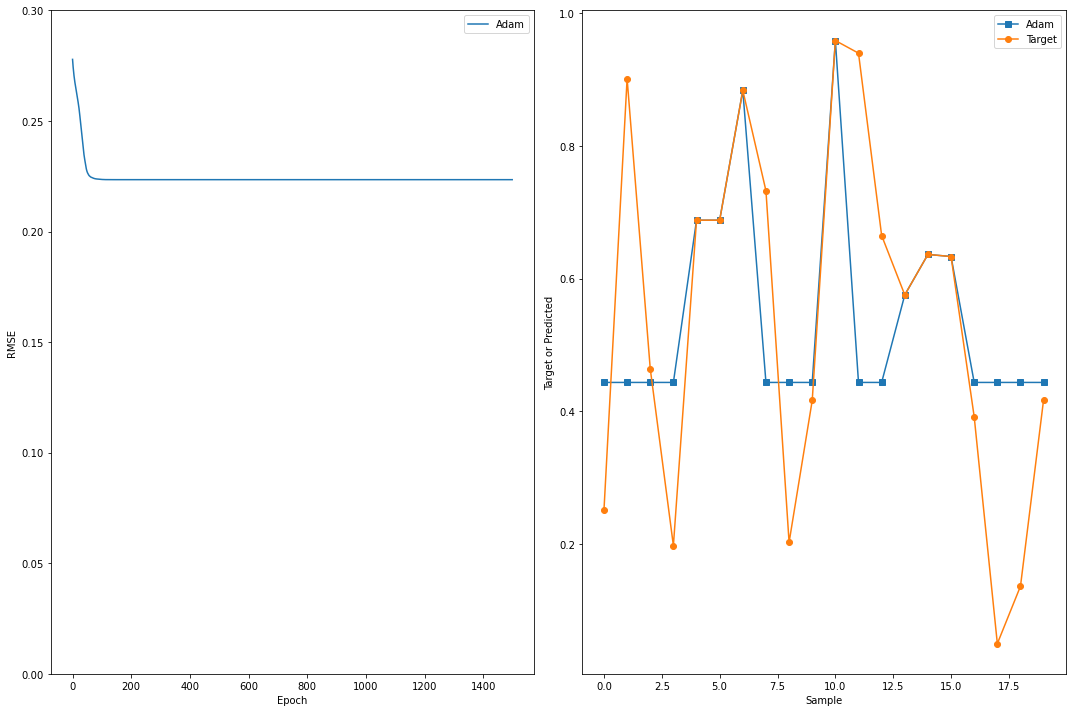

In [9]:
n_hiddens = [2 for _ in range(5)]
n = NNet(1, n_hiddens, 1, method='adam') 

# print(n.model)
n.train(X, T, 1500, 0.01, train_style='batch')
# n.layer_outputs
Y = n.use(X)
print(f'FINAL RMSE: {rmse(Y, T):.2f}')
n.dead_neurons()

# top, bottom = n.dead_neurons(X)
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(n.error_trace, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim((0.0, 0.3))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Y, '-s', label='Adam')
plt.plot(T, '-o', label='Target')
plt.xlabel('Sample')
plt.ylabel('Target or Predicted')
plt.legend()

plt.tight_layout()


In [24]:
for layer in n.model:
    if isinstance(layer, torch.nn.Linear):
        print(layer.bias)

Parameter containing:
tensor([-1.1072, -0.7909], requires_grad=True)
Parameter containing:
tensor([-0.6780, -0.6446], requires_grad=True)
Parameter containing:
tensor([-0.5621, -0.1386], requires_grad=True)
Parameter containing:
tensor([ 0.5427, -0.0642], requires_grad=True)
Parameter containing:
tensor([-0.2902, -0.6503], requires_grad=True)
Parameter containing:
tensor([-0.0450], requires_grad=True)


In [25]:
def display_graph(X, model, lr, n_hiddens, method, iteration, train_style, did_converge):

    depth = f'{len(n_hiddens)}'
    arch = f'[2 for _ in range({len(n_hiddens)})]'
    
    color = 'blue' if method =='Adam' else 'orange'

    conv_or_no_conv = 'c' if did_converge else 'nc'

    lr_dir = None
    if lr == 0.01:
        lr_dir = 'LR0_01'
    elif lr == 0.001:
        lr_dir = 'LR0_001'
    elif lr == 0.1:
        lr_dir = 'LR0_1'
    else:
        raise Exception('{lr} is not a correct learing rate')

    Y = model.use(X)

    plt.figure(figsize=(10,5))

    plt.suptitle(f'{arch}', fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(model.error_trace, color=color, label=method)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0.0, 0.3))
    plt.legend()

    plt.subplot(1, 2, 2)
    
    plt.plot(Y, '-s', color=color, label=method)
    plt.plot(T, '-o', color='green', label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()
    
    plt.savefig(f'Graphs/ResidualConnections/{train_style}/{lr_dir}/{method}_depth_{depth}_it{iteration + 1}_{conv_or_no_conv}.jpeg',  bbox_inches = 'tight')
    plt.close()

In [26]:
def run_experiment(X, T, n_hiddens, lr, method, train_style, verbose=False):
    
    epochs = 3000
    convergence_threshold = 0.07

    if verbose:
        print('--------> {method} <--------')
    model = NNet(1, n_hiddens, 1, method=method, verbose=verbose) 
    start = time.time()
    model.train(X, T, epochs, lr, train_style=train_style,verbose=verbose)
    end = time.time()
    total_time = end - start
    Y = model.use(X)
    final_rmse = rmse(Y, T)
    if verbose:
        print(f'Total Time to Train {(total_time):.3f} seconds')
        print(f'RMSE {final_rmse:.3f}\n')
    
    if verbose:
        print(f'{method} Dead Neurons:')

    dead_neurons, dead_layers = model.dead_neurons(verbose=False)

    return (final_rmse <= convergence_threshold, [dead_neurons, dead_layers, total_time], model)

<br>
<br>
<br>

In [27]:
def update_excel_results(specific_lr, pattern, connection, method, num_conv_or_no_conv, dead_neurons, dead_layers, time, did_converge=False):

    def get_row_start_end(connection, did_converge, method):
        if connection == 'non_residual' and did_converge:
            if method == 'adam':
                row_start = 2
                row_end = 15
            else:
                row_start = 18
                row_end = 31
        
        elif connection == 'residual' and did_converge:
            if method == 'adam':
                row_start = 3
                row_end = 16
            else:
                row_start = 19
                row_end = 32
        
        
        elif connection == 'non_residual' and not did_converge:
            if method == 'adam':
                row_start = 34
                row_end = 47
            else:
                row_start = 50
                row_end = 63
        
        elif connection == 'residual' and not did_converge:
            if method == 'adam':
                row_start = 35
                row_end = 48
            else:
                row_start = 51
                row_end = 65
        else: 

            raise Exception(f'connection must be \'non_residual\' or \'residual\'. Got {connection}')

        return row_start, row_end
                
    df = pd.read_excel('FullClean.xlsx', header=None)
    
    row_start, row_end = get_row_start_end(connection, did_converge, method)

    if pattern == 'iterative':
        total_c_or_nc_column = specific_lr['IT_TOTALCNC']
        dead_neuron_column = specific_lr['IT_DEAD']
        dead_layer_column = specific_lr['IT_DEAD_LAYERS']
        training_time_column = specific_lr['IT_TIME']
        
        
    elif pattern == 'batch':
        total_c_or_nc_column = specific_lr['BATCH_TOTALCNC']
        dead_neuron_column = specific_lr['BATCH_DEAD']
        dead_layer_column = specific_lr['BATCH_DEAD_LAYERS']
        training_time_column = specific_lr['BATCH_TIME']
        
        
    else: 
        raise Exception(f'pattern must be \'iterative\' or \'batch\'. Got {pattern}')


    for row, c_or_no_c, dead_n, dead_l, avg_time in zip(range(row_start, row_end, 2), num_conv_or_no_conv, dead_neurons, dead_layers, time):
        # How many convergence or no convergence
        df.iat[row, total_c_or_nc_column] = c_or_no_c

        # Dead Neurons
        df.iat[row, dead_neuron_column] = round(dead_n, 2)

        # Dead Layers
        df.iat[row, dead_layer_column] = round(dead_l, 2)

        # Training Time
        df.iat[row, training_time_column] = round(avg_time, 3)




    df.to_excel('FullClean.xlsx', sheet_name='Sheet1', index=False, header=False)

In [28]:
def archs_avg(lr, n_hiddens, adam_dead, adam_layers, adam_time, sgd_dead, sgd_layers, sgd_time, did_converge=False):

    conv = 'CONVERGENCE' if did_converge else 'NO CONVERGENCE'
    adam_avg_dead = np.average(adam_dead)
    adam_avg_time = np.average(adam_time)
    adam_avg_layers = np.average(adam_layers)

    sgd_avg_dead = np.average(sgd_dead)
    sgd_avg_time = np.average(sgd_time)
    sgd_avg_layers = np.average(sgd_layers)


    pretty_result = "============================= COMPLETE =============================\n"
    pretty_result += f'------ ARCH: [2 for _ in range({len(n_hiddens)})] LR: {lr} {conv}------\n'
    pretty_result += '****** Adam ******\n'
    pretty_result += f'Dead Neurons: {adam_avg_dead:.2f}\tDead Layers: {adam_avg_layers:.3f}\tTraining Time: {adam_avg_time:.3f}\n\n\n'
    pretty_result += '****** SGD ******\n'
    pretty_result += f'Dead Neurons: {sgd_avg_dead:.2f}\tDead Layers: {sgd_avg_layers:.3f}\tTraining Time: {sgd_avg_time:.3f}\n\n\n'
    pretty_result += "============================= COMPLETE =============================\n\n\n\n"
    
    print(pretty_result)

    return adam_avg_dead, adam_avg_layers, adam_avg_time, sgd_avg_dead, sgd_avg_layers, sgd_avg_time

## Experiment

In [29]:
def get_specific_lr(lr):
    specific_lr = None
    if lr == 0.01:
        specific_lr = {'IT_TOTALCNC': 1, 'IT_DEAD': 2, 'IT_DEAD_LAYERS': 3, 'IT_TIME': 4, 'BATCH_TOTALCNC': 5, 'BATCH_DEAD': 6, 'BATCH_DEAD_LAYERS': 7,'BATCH_TIME': 8}
    elif lr == 0.001:
        specific_lr = {'IT_TOTALCNC': 11, 'IT_DEAD': 12, 'IT_DEAD_LAYERS': 13, 'IT_TIME': 14, 'BATCH_TOTALCNC': 15, 'BATCH_DEAD': 16, 'BATCH_DEAD_LAYERS': 17,'BATCH_TIME': 18}
    elif lr == 0.1:
        specific_lr = {'IT_TOTALCNC': 21, 'IT_DEAD': 22, 'IT_DEAD_LAYERS': 23, 'IT_TIME': 24, 'BATCH_TOTALCNC': 25, 'BATCH_DEAD': 26, 'BATCH_DEAD_LAYERS': 27,'BATCH_TIME': 28}
    else:
        raise Exception(f'{lr} is not a used learning rate.') 
    return specific_lr

In [30]:
from IPython.display import clear_output
def main(lr, train_style):
    n_hiddens = [[2 for _ in range(2)], [2 for _ in range(5)], [2 for _ in range(10)], [2 for _ in range(15)], [2 for _ in range(20)], [2 for _ in range(25)], [2 for _ in range(30)]]

    specific_lr = get_specific_lr(lr)

    adam_conv_all_dead = []
    adam_conv_all_layers = []
    adam_conv_all_time = []
    adam_total_num_conv = []


    adam_no_conv_all_dead = []
    adam_no_conv_all_layers = []
    adam_no_conv_all_time = []
    adam_total_num_no_conv = []
 
    

    sgd_conv_all_dead = []
    sgd_conv_all_layers = []
    sgd_conv_all_time = []
    sgd_total_num_conv = []

    

    sgd_no_conv_all_dead = []
    sgd_no_conv_all_layers = []
    sgd_no_conv_all_time = []
    sgd_total_num_no_conv = []

   


    print(colored('==================STARTING EXPERIMENT==================', 'yellow', attrs=['blink']))


    for arch in n_hiddens:
        adam_num_conv = 0
        adam_conv_dead = []
        adam_conv_layers = []
        adam_conv_time = []
        
        adam_num_no_conv = 0
        adam_no_conv_dead = []
        adam_no_conv_layers = []
        adam_no_conv_time = []
        
        sgd_num_conv = 0
        sgd_conv_dead = []
        sgd_conv_layers = []
        sgd_conv_time = []
        
        sgd_num_no_conv = 0
        sgd_no_conv_dead = []
        sgd_no_conv_layers = []
        sgd_no_conv_time = []
        
        NEURONS = 0
        LAYERS = 1
        TIME = 2

        print(colored(f"################# TRAINING #################", 'magenta', attrs =['blink']))
        print(colored(f'\tARCH: [2 for _ in range({len(arch)})] LR: {lr}', 'magenta', attrs=['blink']))
        print(colored(f"############################################\n", 'magenta', attrs=['blink']))

        for iteration in tqdm(range(10)):
            
            for method in ['adam', 'sgd']:
                did_converge, results, model = run_experiment(X, T, arch, lr, method, train_style=train_style, verbose=False)
                
                if did_converge and method == 'adam':
                    adam_conv_dead.append(results[NEURONS])
                    adam_conv_layers.append(results[LAYERS])
                    adam_conv_time.append(results[TIME])
                    adam_num_conv += 1
                    
                elif did_converge and method == 'sgd':
                    sgd_conv_dead.append(results[NEURONS])
                    sgd_conv_layers.append(results[LAYERS])
                    sgd_conv_time.append(results[TIME])
                    sgd_num_conv += 1

                elif not did_converge and method =='adam':
                    adam_no_conv_dead.append(results[NEURONS])
                    adam_no_conv_layers.append(results[LAYERS])
                    adam_no_conv_time.append(results[TIME])
                    adam_num_no_conv += 1

                elif not did_converge and method == 'sgd':
                    sgd_no_conv_dead.append(results[NEURONS])
                    sgd_no_conv_layers.append(results[LAYERS])
                    sgd_no_conv_time.append(results[TIME])
                    sgd_num_no_conv += 1
                    
                else:
                    raise Exception(f'Either method {method} or did_converge {did_converge} is wrong.')

                display_graph(X, model, lr, arch, method, iteration, train_style, did_converge)

        adam_total_num_conv.append(adam_num_conv)
        adam_total_num_no_conv.append(adam_num_no_conv)

        sgd_total_num_conv.append(sgd_num_conv)
        sgd_total_num_no_conv.append(sgd_num_no_conv)

        # Convergence
        adam_conv_dead_avg, adam_conv_layer_avg, adam_conv_time_avg, sgd_conv_dead_avg, sgd_conv_layer_avg, sgd_conv_time_avg = \
                archs_avg(lr, arch, adam_conv_dead, adam_conv_layers, adam_conv_time, sgd_conv_dead, sgd_conv_layers, sgd_conv_time, did_converge=True)


        adam_conv_all_dead.append(adam_conv_dead_avg)
        adam_conv_all_layers.append(adam_conv_layer_avg)
        adam_conv_all_time.append(adam_conv_time_avg)


        sgd_conv_all_dead.append(sgd_conv_dead_avg)
        sgd_conv_all_layers.append(sgd_conv_layer_avg)
        sgd_conv_all_time.append(sgd_conv_time_avg)
  


        # No Convergence
        adam_no_conv_dead_avg, adam_no_conv_layer_avg, adam_no_conv_time_avg, sgd_no_conv_dead_avg, sgd_no_conv_layer_avg, sgd_no_conv_time_avg = \
                archs_avg(lr, arch, adam_no_conv_dead, adam_no_conv_layers, adam_no_conv_time, sgd_no_conv_dead, sgd_no_conv_layers, sgd_no_conv_time)


        adam_no_conv_all_dead.append(adam_no_conv_dead_avg)
        adam_no_conv_all_layers.append(adam_no_conv_layer_avg)
        adam_no_conv_all_time.append(adam_no_conv_time_avg)


        sgd_no_conv_all_dead.append(sgd_no_conv_dead_avg)
        sgd_no_conv_all_layers.append(sgd_no_conv_layer_avg)
        sgd_no_conv_all_time.append(sgd_no_conv_time_avg)

        clear_output(wait=True)
        
    update_excel_results(specific_lr, train_style, 'residual', 'adam', adam_total_num_conv, adam_conv_all_dead, adam_conv_all_layers, adam_conv_all_time, did_converge=True)
    update_excel_results(specific_lr, train_style, 'residual', 'adam', adam_total_num_no_conv, adam_no_conv_all_dead, adam_no_conv_all_layers, adam_no_conv_all_time)

    update_excel_results(specific_lr, train_style, 'residual', 'sgd', sgd_total_num_conv, sgd_conv_all_dead, sgd_conv_all_layers, sgd_conv_all_time, did_converge=True)
    update_excel_results(specific_lr, train_style, 'residual', 'sgd', sgd_total_num_no_conv, sgd_no_conv_all_dead, sgd_no_conv_all_layers, sgd_no_conv_all_time)


    print(colored('==================EXPERIMENT COMPLETE ==================', 'yellow', attrs=['blink']))



In [31]:
def run_all():
    main(lr=0.01, train_style='iterative')
    main(lr=0.001, train_style='iterative')
    main(lr=0.1, train_style='iterative')

    main(lr=0.01, train_style='batch')
    main(lr=0.001, train_style='batch')
    main(lr=0.1, train_style='batch')

In [32]:
run_all()

==================EXPERIMENT COMPLETE ==================
